In [1]:
%load_ext zipline

,algo_volatility,algorithm_period_return,alpha,bb_lower,bb_upper,benchmark_period_return,benchmark_volatility,beta,capital_used,ending_cash,...,short_exposure,short_value,shorts_count,sortino,starting_cash,starting_exposure,starting_value,trading_days,transactions,treasury_period_return
2019-03-11 06:30:00+00:00,NaN,0.000000,None,42789.646916,48100.353084,0.0,NaN,None,0.000000e+00,1.000000e+07,...,0.0,0.0,0,NaN,1.000000e+07,0.0,0.0,1,[],0.0
2019-03-12 06:30:00+00:00,0.000000,0.000000,None,42509.095903,47680.904097,0.0,0.0,None,0.000000e+00,1.000000e+07,...,0.0,0.0,0,NaN,1.000000e+07,0.0,0.0,2,[],0.0
2019-03-13 06:30:00+00:00,0.000000,0.000000,None,42717.750608,46932.249392,0.0,0.0,None,0.000000e+00,1.000000e+07,...,0.0,0.0,0,NaN,1.000000e+07,0.0,0.0,3,[],0.0
2019-03-14 06:30:00+00:00,0.000000,0.000000,None,42802.343081,46267.656919,0.0,0.0,None,0.000000e+00,1.000000e+07,...,0.0,0.0,0,NaN,1.000000e+07,0.0,0.0,4,[],0.0
2019-03-15 06:30:00+00:00,0.000000,0.000000,None,43301.125008,45188.874992,0.0,0.0,None,0.000000e+00,1.000000e+07,...,0.0,0.0,0,NaN,1.000000e+07,0.0,0.0,5,[],0.0
2019-03-18 06:30:00+00:00,0.000000,0.000000,None,43402.072381,44907.927619,0.0,0.0,None,0.000000e+00,1.000000e+07,...,0.0,0.0,0,NaN,1.000000e+07,0.0,0.0,6,[],0.0
2019-03-19 06:30:00+00:00,0.000000,0.000000,None,43404.704793,44675.295207,0.0,0.0,None,0.000000e+00,1.000000e+07,...,0.0,0.0,0,NaN,1.000000e+07,0.0,0.0,7,[],0.0
2019-03-20 06:30:00+00:00,0.000000,0.000000,None,43381.381527,44628.618473,0.0,0.0,None,0.000000e+00,1.000000e+07,...,0.0,0.0,0,NaN,1.000000e+07,0.0,0.0,8,[],0.0
2019-03-21 06:30:00+00:00,0.000000,0.000000,None,43385.820539,44634.179461,0.0,0.0,None,0.000000e+00,1.000000e+07,...,0.0,0.0,0,NaN,1.000000e+07,0.0,0.0,9,[],0.0
2019-03-22 06:30:00+00:00,0.001635,-0.000326,None,42889.841280,45410.158720,0.0,0.0,None,9.277429e+05,1.092774e+07,...,-931000.0,-931000.0,1,-5.019960,1.000000e+07,0.0,0.0,10,"[{'dt': 2019-03-22 06:30:00+00:00, 'amount': -...",0.0


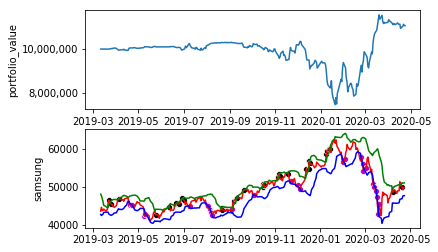

In [7]:
%%zipline --start 2019-3-10 --end 2020-4-23 --bundle kor_stocks --trading-calendar XKRX  -o kor_test.pickle 
from zipline.finance.commission import PerDollar

import logging
logging.basicConfig(level=logging.WARNING)

# commision
class KorCom(PerDollar):
    def calculate(self, order, transaction):
        """
        Pay commission based on dollar value of shares.
        """
        if order.amount > 0:
            cost_per_share = 0
        else:
            cost_per_share = transaction.price * self.cost_per_dollar
        return abs(transaction.amount) * cost_per_share

# pipeline
from zipline.pipeline import Pipeline
from zipline.pipeline.factors import BollingerBands

def make_pipeline():
    bb = BollingerBands(window_length=10, k=2)
    return Pipeline(
        columns={
            'upper': bb.upper,
            'middle': bb.middle,
            'lower': bb.lower,
        },
    )

# trading
from zipline.api import order, record, symbol, attach_pipeline, pipeline_output, schedule_function, date_rules

def initialize(context):
    attach_pipeline(make_pipeline(), 'pipeline_data')
    context.set_commission(KorCom(cost=0.003))
    schedule_function(handle_data, date_rules.every_day())

    context.i = 0
    context.asset=symbol("005930")

def handle_data(context, data):

    record(i=context.i)
    context.i += 1

    context.pipeline_data = pipeline_output('pipeline_data')

    if data.current(context.asset, 'price') > context.pipeline_data["upper"][0]:
        order(context.asset, -10)
    elif data.current(context.asset, 'price') < context.pipeline_data["lower"][0]:
        order(context.asset, 10)

    record(samsung=data.current(context.asset, 'price'))
    record(bb_upper=context.pipeline_data["upper"][0])
    record(bb_lower=context.pipeline_data["lower"][0])

# analyze
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

def analyze(context, perf):

    ax1 = plt.subplot(211)

    fmt = '{x:,.0f}'
    tick = mtick.StrMethodFormatter(fmt)
    ax1.yaxis.set_major_formatter(tick)

    g = sns.lineplot(x=perf.index, y=perf["portfolio_value"], ax=ax1)

    ax2 = plt.subplot(212)
    sns.lineplot(x=perf.index, y=perf["samsung"], ax=ax2, color="red")
    sns.lineplot(x=perf.index, y=perf["bb_upper"], ax=ax2, color="green")
    sns.lineplot(x=perf.index, y=perf["bb_lower"], ax=ax2, color="blue")

    # 거래시기
    buys = list()
    sells = list()

    for t in perf.transactions:
        if len(t) > 0:
            buys.append(t[0]['amount'] > 0)
            sells.append(t[0]['amount'] < 0)
        else:
            buys.append(False)
            sells.append(False)

    buys = perf.ix[buys]
    sells = perf.ix[sells]

    sns.scatterplot(buys.index, perf.samsung.ix[buys.index],  markers='^', color='m',ax=ax2)
    sns.scatterplot(sells.index, perf.samsung.ix[sells.index], markers='v', color='k',ax=ax2)